# Solving the Phillips-Wunsch-Garrett IVP with non-constant coefficients using Dedalus

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
from dedalus import public as de
from dedalus.extras import flow_tools
from dedalus.extras import plot_tools
from dedalus.tools import post
import pathlib
import time
from IPython import display

import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")

logger = logging.getLogger(__name__)

# Problem formulation

### Physical parameters

In [32]:
N = 1.3e-3
f = 0.53e-4

# topographic parameters
slopeAngle = 2.e-3
tht = slopeAngle

# mixing parameters
d = 230
k0 = 5.2e-5
k1 = 1.8e-3
Pr = 1

In [33]:
def calc_delta():
    return ((4*Pr**2*(k0+k1)**2) / (f**2*np.cos(tht)**2 * (1 + (N**2*np.tan(tht)**2/(f**2))*Pr)))**0.25

In [34]:
#===== Set up domain =====
# Create basis and domain for all experiments
Lz = 4000
nz = 512
z_basis = de.Chebyshev('z', nz, interval=(0, Lz), dealias=3/2)
domain = de.Domain([z_basis], np.float64)
z = domain.grid(0)

#===== Set up Problem ======
problem = de.IVP(domain, variables=['u', 'v', 'b', 'uz', 'vz', 'bz']);

# Set parameters
problem.parameters['f'] = f
problem.parameters['tht'] = tht # set in loop
problem.parameters['N'] = N
k = domain.new_field(name='k')
k['g'] = k0+k1*np.exp(-z/d)
problem.parameters['k'] = k

nu = domain.new_field(name='nu')
nu['g'] = (k0+k1*np.exp(-z/d))*Pr
problem.parameters['nu'] = nu

# Main equations
problem.add_equation("-f*cos(tht)*v - sin(tht)*b - dz(nu*uz) = 0")
problem.add_equation("f*u*cos(tht) - dz(nu*vz) = 0")
problem.add_equation("dt(b) + N**2*sin(tht)*u - dz(k*bz) = N**2*cos(tht)*dz(k)")

# Auxiliary equations defining the first-order reduction
problem.add_equation("uz - dz(u) = 0")
problem.add_equation("vz - dz(v) = 0")
problem.add_equation("bz - dz(b) = 0")

# Boundary conditions
problem.add_bc('left(u) = 0')
problem.add_bc('left(v) = 0')
problem.add_bc('left(bz) = - N**2*cos(tht)')
problem.add_bc('right(uz) = 0')
problem.add_bc('right(vz) = 0')
problem.add_bc('right(bz) = 0')

# Set solver for IVP
solver = problem.build_solver(de.timesteppers.RK443);

#==== Set initial conditions ====
# Reference local grid and state fields
z = domain.grid(0)
u = solver.state['u']
v = solver.state['v']
b = solver.state['b']
uz = solver.state['uz']
vz = solver.state['vz']
bz = solver.state['bz']

# State from a state of rest
u['g'] = np.zeros_like(z)
v['g'] = np.zeros_like(z)
b['g'] = np.zeros_like(z)
u.differentiate('z', out=uz)
v.differentiate('z', out=vz)
b.differentiate('z', out=bz)

#==== Create analysis files ====
#analysis = solver.evaluator.add_file_handler('analysis', iter=1, max_writes=100)
#analysis.add_system(solver.state, layout='g')

# Stop stopping criteria
solver.stop_sim_time = (50.*24.*60.*60.)
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

# Setup storage
u_list = [np.copy(u['g'])]
v_list = [np.copy(v['g'])]
b_list = [np.copy(b['g'])]
bz_list = [np.copy(bz['g'])]
t_list = [solver.sim_time]

# Main loop
dt = 3*60.*60.
start_time = time.time()
print('Iterations: ')
while solver.ok:
    solver.step(dt);
    if solver.sim_time % (3.*60.*60.) == 0:
        print(np.int64(solver.sim_time/60.), end=", ")
        u_list.append(np.copy(u['g']))
        v_list.append(np.copy(v['g']))
        b_list.append(np.copy(b['g']))
        bz_list.append(np.copy(bz['g']))
        t_list.append(solver.sim_time)
        
end_time = time.time()
print('Runtime:', end_time-start_time)
z_da = domain.grid(0, scales=domain.dealias)

2020-01-13 14:57:31,215 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+00/s
Iterations: 
180, 360, 540, 720, 900, 1080, 1260, 1440, 1620, 1800, 1980, 2160, 2340, 2520, 2700, 2880, 3060, 3240, 3420, 3600, 3780, 3960, 4140, 4320, 4500, 4680, 4860, 5040, 5220, 5400, 5580, 5760, 5940, 6120, 6300, 6480, 6660, 6840, 7020, 7200, 7380, 7560, 7740, 7920, 8100, 8280, 8460, 8640, 8820, 9000, 9180, 9360, 9540, 9720, 9900, 10080, 10260, 10440, 10620, 10800, 10980, 11160, 11340, 11520, 11700, 11880, 12060, 12240, 12420, 12600, 12780, 12960, 13140, 13320, 13500, 13680, 13860, 14040, 14220, 14400, 14580, 14760, 14940, 15120, 15300, 15480, 15660, 15840, 16020, 16200, 16380, 16560, 16740, 16920, 17100, 17280, 17460, 17640, 17820, 18000, 18180, 18360, 18540, 18720, 18900, 19080, 19260, 19440, 19620, 19800, 19980, 20160, 20340, 20520, 20700, 20880, 21060, 21240, 21420, 21600, 21780, 21960, 22140, 22320, 22500, 22680, 22860, 23040, 23220, 23400, 23580, 23760, 2

In [35]:
u = np.array(u_list)
v = np.array(v_list)
b = np.array(b_list)
bz = np.array(bz_list)
t = np.array(t_list)

Text(0, 0.5, 'height above bottom [m]')

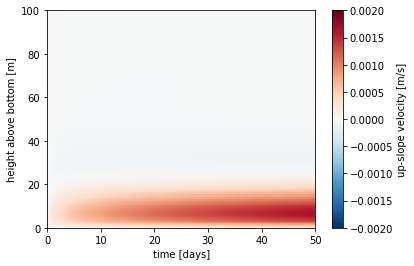

In [36]:
plt.pcolormesh(t/(86400.), z_da, u.swapaxes(0, 1), cmap='RdBu_r')
plt.colorbar(label='up-slope velocity [m/s]')
plt.clim([-2.e-3,2.e-3])
plt.ylim([0,100])
plt.xlabel('time [days]')
plt.ylabel('height above bottom [m]')

In [23]:
u.max()

0.0016521997074527128

2019-07-15 16:20:08,944 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2019-07-15 16:20:09,599 solvers 0/1 INFO :: Stop iteration reached.
2019-07-15 16:20:10,208 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2019-07-15 16:20:10,894 solvers 0/1 INFO :: Stop iteration reached.
2019-07-15 16:20:11,521 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2019-07-15 16:20:12,275 solvers 0/1 INFO :: Stop iteration reached.
2019-07-15 16:20:12,884 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2019-07-15 16:20:13,542 solvers 0/1 INFO :: Stop iteration reached.
2019-07-15 16:20:14,144 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2019-07-15 16:20:14,812 solvers 0/1 INFO :: Stop iteration reached.
2019-07-15 16:20:15,584 pencil 0/1 INFO :: Buildin

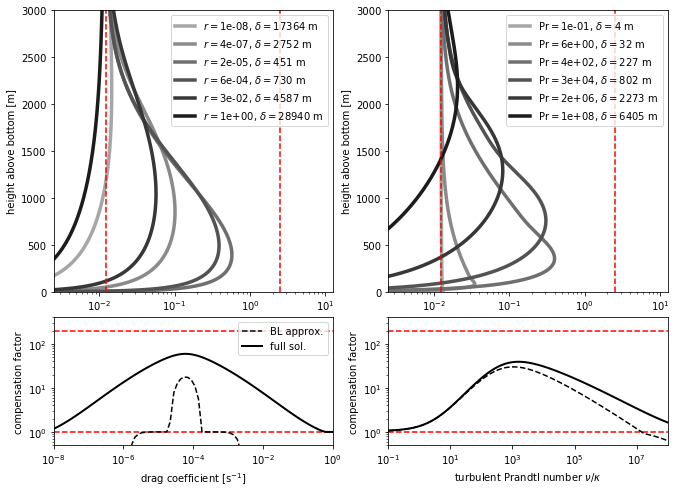

In [70]:
plt.figure(figsize=(11,8))
ndrag = 6

rs=np.logspace(-8,0,ndrag)
Prs=np.logspace(-1,8,ndrag)

u_list = []
i=0
for r in rs:
    u, v, bz, t, z = run_spinup_drag(r)
    u_list.append(u[-1,:])
    i+=1
    
nu_ratio_label = r"$r=$"

zf = (z[1:]+z[:-1])/2.0

plt.subplot2grid((3, 2), (0, 0), rowspan=2)
i=0
for r in rs:
    plt.semilogx(np.cumsum(0.5*(u_list[i][1:]+u_list[i][:-1])*np.diff(z)),zf,
             label=nu_ratio_label+str("{:.0e}".format(r))+', $\delta = $'+str(np.int(round(calc_delta_drag(r),0)))+" m",
             color=(0.65-0.65*i/len(rs),0.65-0.65*i/len(rs),0.65-0.65*i/len(rs)),
             lw=3.5)
    i+=1
plt.semilogx([k0*np.tan(tht)**-1,k0*np.tan(tht)**-1],[0,3000],"r--",lw=1.5)
plt.semilogx([k1*np.tan(tht)**-1,k1*np.tan(tht)**-1],[0,3000],"r--",lw=1.5)
plt.legend()
plt.xlabel(r'cross-slope transport [m$^{2}$/s]')
plt.ylabel('height above bottom [m]')
plt.ylim([0,3000])
plt.xlim([k0*np.tan(tht)**-1*0.2,k1*np.tan(tht)**-1*5])

u_list = []
i=0
for Pr in Prs:
    u, v, bz, t, z = run_spinup_diff(Pr)
    u_list.append(u[-1,:])
    i+=1

nu_ratio_label = r"Pr$=$"

zf = (z[1:]+z[:-1])/2.0

plt.subplot2grid((3, 2), (0, 1), rowspan=2)
i=0
for Pr in Prs:
    plt.semilogx(np.cumsum(0.5*(u_list[i][1:]+u_list[i][:-1])*np.diff(z)),zf,
             label=nu_ratio_label+str("{:.0e}".format(Pr))+', $\delta = $'+str(np.int(round(calc_delta_diff(Pr),0)))+" m",
             color=(0.65-0.65*i/len(Prs),0.65-0.65*i/len(Prs),0.65-0.65*i/len(Prs)),
             lw=3.5)
    i+=1
plt.semilogx([k0*np.tan(tht)**-1,k0*np.tan(tht)**-1],[0,3000],"r--",lw=1.5)
plt.semilogx([k1*np.tan(tht)**-1,k1*np.tan(tht)**-1],[0,3000],"r--",lw=1.5)
plt.legend()
plt.xlabel(r'cross-slope transport [m$^{2}$/s]')
plt.ylabel('height above bottom [m]')
plt.ylim([0,3000])
plt.xlim([k0*np.tan(tht)**-1*0.2,k1*np.tan(tht)**-1*5])


#############
ndrag = 80

plt.subplot2grid((3, 2), (2, 0))
rs=np.logspace(-8,0,ndrag)

plt.loglog([rs[0],rs[-1]],[1,1],"r--",lw=1.5)
plt.loglog([rs[0],rs[-1]],[k1/k0,k1/k0],"r--",lw=1.5)

# Prediction form Boundary Layer Approximation
psi_max_list = []
for r in rs:
    S = N**2*np.tan(tht)**2*f**-2
    psi_out = np.tan(tht)**-1*(k0+k1*np.exp(-z/d))
    psi_in = (
        -np.tan(tht)**-1*(k0+k1)*np.exp(-z/calc_delta_drag(r))
    )
    psi_max_list.append(np.max(psi_out+psi_in))
    
plt.loglog(rs,np.array(psi_max_list)/(k0*np.tan(tht)**-1),"k--",lw=1.5,label="BL approx.")

# Full solution
psi_max_list = []
i=0
for r in rs:
    u, v, bz, t, z = run_spinup_drag(r)
    zf = (z[1:]+z[:-1])/2.0
    psi_max_list.append(np.max(np.cumsum(0.5*(u[-1,:][1:]+u[-1,:][:-1])*np.diff(z))))
    i+=1

plt.loglog(rs,np.array(psi_max_list)/(k0*np.tan(tht)**-1),"k-",lw=2.,label="full sol.")
plt.xlim([rs[0],rs[-1]])
plt.xlabel(r"drag coefficient [s$^{-1}$]")
plt.ylim([0.5,k1/k0*2])
plt.ylabel("compensation factor")
plt.legend()

##########
plt.subplot2grid((3, 2), (2, 1))
Prs=np.logspace(-1,8,ndrag)

plt.loglog([Prs[0],Prs[-1]],[1,1],"r--",lw=1.5)
plt.loglog([Prs[0],Prs[-1]],[k1/k0,k1/k0],"r--",lw=1.5)

# Prediction form Boundary Layer Approximation
psi_max_list = []
for Pr in Prs:
    S = N**2*np.tan(tht)**2*f**-2
    psi_out = np.tan(tht)**-1*(k0+k1*np.exp(-z/d)*(S*Pr)/(1+S*Pr))
    psi_in = (
        -(k0+k1*np.exp(-z/d)*(S*Pr)/(1+S*Pr)) *
        np.tan(tht)**-1*np.exp(-z/calc_delta_diff(Pr)) *
        (np.cos(z/calc_delta_diff(Pr)) + np.sin(z/calc_delta_diff(Pr)))
    )
    psi_max_list.append(np.max(psi_out+psi_in))
    
plt.loglog(Prs,np.array(psi_max_list)/(k0*np.tan(tht)**-1),"k--",lw=1.5,label="BL approx.")

# Full solution
psi_max_list = []
i=0
for Pr in Prs:
    u, v, bz, t, z = run_spinup_diff(Pr)
    zf = (z[1:]+z[:-1])/2.0
    psi_max_list.append(np.max(np.cumsum(0.5*(u[-1,:][1:]+u[-1,:][:-1])*np.diff(z))))
    i+=1

plt.loglog(Prs,np.array(psi_max_list)/(k0*np.tan(tht)**-1),"k-",lw=2.,label="full sol.")
plt.xlim([Prs[0],Prs[-1]])
plt.xlabel(r"turbulent Prandtl number $\nu/\kappa$")
plt.ylim([0.5,k1/k0*2])
plt.ylabel("compensation factor")


plt.savefig("../figures/cross_slope_transport.png",bbox_inches="tight",dpi=100)